In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
conversion_period=9
base_period=26
leading_span_b_period=52
displacement=26
n_past=10
n_future=1

In [2]:
df = yf.download('SBIN.NS', start='2022-01-01', end='2023-07-17',interval='1h')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-01-03 09:15:00+05:30,462.100006,465.000000,460.100006,465.000000,465.000000,0
2022-01-03 10:15:00+05:30,465.000000,467.200012,464.149994,467.100006,467.100006,2389531
2022-01-03 11:15:00+05:30,467.000000,467.100006,465.299988,466.299988,466.299988,960631
2022-01-03 12:15:00+05:30,466.399994,467.899994,466.299988,467.500000,467.500000,1386992
2022-01-03 13:15:00+05:30,467.600006,470.250000,467.200012,469.899994,469.899994,1889395
...,...,...,...,...,...,...
2023-07-14 11:15:00+05:30,584.400024,585.500000,582.099976,583.000000,583.000000,1284962
2023-07-14 12:15:00+05:30,582.950012,583.700012,581.000000,582.150024,582.150024,1178049
2023-07-14 13:15:00+05:30,582.099976,582.849976,580.700012,581.299988,581.299988,1142539


In [3]:
def sma(period,series):
    sma_points=[]
    for i in range(0,len(series)-period+1):        
        sum_value= series[i:i+period].sum()
        mean = sum_value/period
        sma_points.append(mean)
    return sma_points
#EMA(Today)= Price(Today)*k +EMA(Yesterday)*(1-k)
def ema(period,series):
    sf=2/(period+1)
    ema_points=[]
    ema_points.append((series[0])*sf + sma(period,series)[0]*(1-sf))
    ema_temp = (series[0])*sf + sma(period,series)[0]*(1-sf)
    for i in range(1,len(series)):
        ema_val = series[i]*sf + ema_temp*(1-sf)
        ema_temp = ema_val
        ema_points.append(ema_val)
    return (ema_points)
'''RSI FUNCTION'''

def rsi(period,series):
    def gain_loss(series):
        series=np.array(series)
        #print(f'series in gain_loss {series}')
        change_list=[]
        gains=[]
        losses=[]
        for i in range(len(series)-1):
            change_list.append(series[i+1]-series[i])
        for k in change_list:
            if k>0:
                gains.append(round(k,2))
            else:
                gains.append(0)
        for j in change_list:
            if j<0:
                losses.append(abs(round(j,2)))
            else:
                losses.append(0)
        return [gains,losses]

    def avg_gain_loss(period,series):
        series = np.array(series)
        average_gains=[]
        #print(f'series in avg_gain_loss {series}')
        avg = series[:period].mean()
        average_gains.append(round(avg,2))
        prev_avg_gain=avg
        for i in range(period,len(series)):
            avg_gain_val = ((prev_avg_gain*(period-1))+series[i])/period
            prev_avg_gain = avg_gain_val
            average_gains.append(round(avg_gain_val,2))
        return(average_gains)
    Gain=gain_loss(series)[0]
    Loss=gain_loss(series)[1]
    Avg_Gains=avg_gain_loss(period,Gain)
    Avg_Loss=avg_gain_loss(period,Loss)
    RS = [round(x/y,2) for x,y in zip(Avg_Gains,Avg_Loss)]
    RSI=[round((100-(100)/(1+rs)),2) for rs in RS]
    RSI= np.array(RSI)
    return pd.Series(RSI,index=df.index[period:])
'''MACD'''
def MACD(period,series):
    def sma(period,series):
        sma_points=[]
        for i in range(0,len(series)-period+1):        
            sum_value= series[i:i+period].sum()
            mean = sum_value/period
            sma_points.append(mean)
        return sma_points
#EMA(Today)= Price(Today)*k +EMA(Yesterday)*(1-k)
    def ema(period,series):
        sf=2/(period+1)
        ema_points=[]
        ema_points.append((series[0])*sf + sma(period,series)[0]*(1-sf))
        ema_temp = (series[0])*sf + sma(period,series)[0]*(1-sf)
        for i in range(1,len(series)):
            ema_val = series[i]*sf + ema_temp*(1-sf)
            ema_temp = ema_val
            ema_points.append(ema_val)
        return (ema_points)

    macd=[element1 - element2 for (element1, element2) in zip(ema(9,series), ema(26,series))]
    macd = np.array(macd)

    return pd.Series(macd,index=df.index)

'''ATR'''
def CalcAverageTrueRange(data, period):
    def CalcTrueRange(high, low, cpy):
        a = high-low
        b = abs(high-cpy)
        c = abs(low-cpy)
        TR = max(a , b ,c )
        return TR
    ATRlist = []
    
    for i in range(period, len(data)):
        tr = CalcTrueRange(data['High'].iloc[i], data['Low'].iloc[i], data['Close'].iloc[i-1])
        # atr = tr if i == NOP else ( AtrList[-1] * (NOP - 1) + tr) / NOP
        
        if i==period:
            atr=tr
        else:
            atr=( ATRlist[-1] * (period - 1) + tr) / period
        ATRlist.append(atr)
    
    return pd.Series( ATRlist , index=data.index[period:])
'''"ICHIMOKU CLOUD'''
conversion_period=9
base_period=26
leading_span_b_period=52
displacement=26
def ic(df, conversion_period=9, base_period=26, leading_span_b_period=52, displacement=26):
    df['ConversionLine'] = (df['High'].rolling(window=conversion_period).max() + df['Low'].rolling(window=conversion_period).min()) / 2
    df['BaseLine'] = (df['High'].rolling(window=base_period).max() + df['Low'].rolling(window=base_period).min()) / 2
    df['LeadingSpanA'] = ((df['ConversionLine'] + df['BaseLine']) / 2).shift(displacement)
    df['LeadingSpanB'] = ((df['High'].rolling(window=leading_span_b_period).max() + df['Low'].rolling(window=leading_span_b_period).min()) / 2).shift(displacement)
    df['LaggingSpan'] = df['Close'].shift(-displacement)
    
    return df[['ConversionLine','BaseLine','LeadingSpanA','LeadingSpanB','LaggingSpan']]
'''EOM'''

def eom(df, period=14):
    hld = df['High'] - df['Low']
    hla = (df['High'] + df['Low']) / 2
    volume = df['Volume']

    dm = (hla.diff(1) / hld) - (hla.shift(1).diff(1) / hld)
    emv = dm * (volume / (hld * 1000000))

    emvsmoothed = np.array(emv.rolling(window=period).mean())

    return pd.Series(emvsmoothed,index=df.index)
'''KC'''
def kc(df, period=20, multiplier=2):

    typical_price = (df['High'] + df['Low'] + df['Close']) / 3

    middle = np.array(ema(period,typical_price))
    atr = np.array(CalcAverageTrueRange(df,20))
    upper = middle[period:] + (multiplier * atr)
    lower = middle[period:] - (multiplier * atr)
    upper=pd.Series(upper,index=df.index[period:])
    middle =pd.Series(middle,index=df.index)
    lower=pd.Series(lower,index=df.index[period:])
    df['Upper']=upper
    df['Lower']=lower
    df['Middle']=middle
    return df[['Upper','Middle','Lower']]

In [4]:
ic(df)
kc(df)
dictionary = {'rsi':rsi(14,df['Close']),'macd':MACD(14,df['Close']),'eom':eom(df),'atr':CalcAverageTrueRange(df,14)}
df['RSI']=rsi(14,df['Close'])
df['MACD-SIGNAL']=MACD(14,df['Close'])-ema(9,MACD(14,df['Close']))
df['EOM']=eom(df)
df['ATR']=CalcAverageTrueRange(df,14)
df
df = df.dropna()
df=df.drop(['Adj Close'],axis=1)


In [5]:

df['CONV-BASE'] = df['ConversionLine']-df['BaseLine']
df['CONV-BASE'] = df['ConversionLine']-df['BaseLine']
df['a-b']=df['LeadingSpanA']-df['LeadingSpanB']
df['Upper New']=df['Upper']-df['Close']
df['Lower New']=df['Lower']-df['Close']
df['EMA']=ema(4,df['Close'])
df=df.drop(['ConversionLine','BaseLine','Open','LeadingSpanA','LeadingSpanB','Lower','Middle','ATR','Upper'],axis=1)


In [6]:
df


,High,Low,Close,Volume,LaggingSpan,RSI,MACD-SIGNAL,EOM,CONV-BASE,a-b,Upper New,Lower New,EMA
Datetime,,,,,,,,,,,,,
2022-01-18 09:15:00+05:30,515.650024,511.700012,513.049988,0,501.350006,57.26,-0.178965,0.021941,0.975006,17.125000,4.244973,-7.201521,513.387497
2022-01-18 10:15:00+05:30,513.049988,510.100006,512.349976,1149635,504.049988,55.36,-0.390392,-0.037673,1.250000,16.075005,4.978736,-6.485429,512.972488
2022-01-18 11:15:00+05:30,514.000000,512.250000,513.150024,883611,503.850006,57.45,-0.442701,0.116865,2.275009,15.587509,4.213437,-7.027520,513.043503
2022-01-18 12:15:00+05:30,516.349976,511.799988,515.900024,1454277,501.750000,63.24,-0.199635,0.045652,1.275009,15.087509,1.917445,-9.671462,514.186111
2022-01-18 13:15:00+05:30,517.400024,514.650024,515.349976,2295064,496.350006,61.24,-0.128873,0.056043,1.525009,14.637497,2.812484,-8.746977,514.651657
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10 13:15:00+05:30,595.000000,593.200012,593.250000,1136447,583.000000,57.08,-0.149163,-0.091626,0.000000,7.587509,4.514374,-7.921155,593.715912
2023-07-10 14:15:00+05:30,593.250000,590.250000,592.849976,1639138,582.150024,56.14,-0.303431,-0.196097,0.375000,7.587509,4.957800,-7.455952,593.369538
2023-07-10 15:15:00+05:30,593.900024,591.700012,591.950012,820580,581.299988,53.70,-0.498815,-0.026822,1.975006,7.587509,5.854639,-6.378429,592.801728


In [7]:
scaler = MinMaxScaler()
scaler = scaler.fit(df)
data_scaled = scaler.transform(df)
train_size=int(len(data_scaled)*0.9)
test_size = len(data_scaled)-train_size
train_scaled,test_scaled = data_scaled[:train_size],data_scaled[train_size:len(data_scaled)]
train_data,test_data = df[:train_size],df[train_size:len(df)]



In [8]:
def to_sequences(df_for_training_scaled,df_for_training,n_past,n_future=1):
    trainx=[]
    trainy=[]
    for i in range(n_past, len(df_for_training_scaled) - n_future +1):
        trainx.append(df_for_training_scaled[i - n_past:i, 1:df_for_training.shape[1]])
        trainy.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

    trainx, trainy = np.array(trainx), np.array(trainy)
    return trainx,trainy

print('trainX shape == {}.'.format(to_sequences(train_scaled,train_data,14)[0].shape))
print('trainY shape == {}.'.format(to_sequences(train_scaled,train_data,14)[1].shape))



trainX shape == (2275, 14, 12).
trainY shape == (2275, 1).


In [9]:
trainX,trainY = to_sequences(train_scaled,train_data,n_past)
testX,testY = to_sequences(test_scaled,test_data,n_past)



In [10]:

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1], trainX.shape[2], 1)
trainY = trainY.reshape(trainY.shape[0], 1)
testX=testX.reshape(testX.shape[0], testX.shape[1], testX.shape[2], 1)
testY=testY.reshape(testY.shape[0],1)
trainX.shape

(2279, 10, 12, 1)

In [11]:
# ConvolutionalLSTM
model = tf.keras.Sequential([tf.keras.layers.ConvLSTM2D(filters=64,kernel_size=(1,1),activation='tanh',input_shape=(trainX.shape[1],trainX.shape[2],1,1)),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(1000),
                            tf.keras.layers.Dense(500),
                            tf.keras.layers.Dense(100),
                            tf.keras.layers.Dense(1)])
model.compile(optimizer='adam',loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 12, 1, 64)         16896     
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 1000)              769000    
                                                                 
 dense_1 (Dense)             (None, 500)               500500    
                                                                 
 dense_2 (Dense)             (None, 100)               50100     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,336,597
Trainable params: 1,336,597
Non-

In [12]:
# #Normal STACKED LSTM
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.LSTM(64,  input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True)) 
# tf.keras.layers.Dropout(0.2)
# model.add(tf.keras.layers.LSTM(32, return_sequences=True))
# model.add(tf.keras.layers.LSTM(16, return_sequences=False))
# model.add(tf.keras.layers.Dense(trainY.shape[1]))

# model.compile(optimizer='adam', loss='mse')
# model.summary()

In [13]:
# #CONV 1D
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
# model.add(tf.keras.layers.MaxPooling1D(2))
# model.add(tf.keras.layers.LSTM(64, return_sequences=True))
# model.add(tf.keras.layers.LSTM(32, return_sequences=False))
# model.add(tf.keras.layers.Dense(trainY.shape[1]))

# model.compile(optimizer='adam', loss='mse')
# model.summary()


In [15]:

history = model.fit(trainX, trainY, epochs=3,batch_size=2, validation_split=0.2, verbose=1)


Epoch 1/3
912/912 [==============================] - 56s 52ms/step - loss: 0.0080 - val_loss: 2.7809e-04
Epoch 2/3
912/912 [==============================] - 44s 48ms/step - loss: 9.0955e-04 - val_loss: 4.3672e-04
Epoch 3/3
912/912 [==============================] - 57s 62ms/step - loss: 0.0010 - val_loss: 1.7376e-04


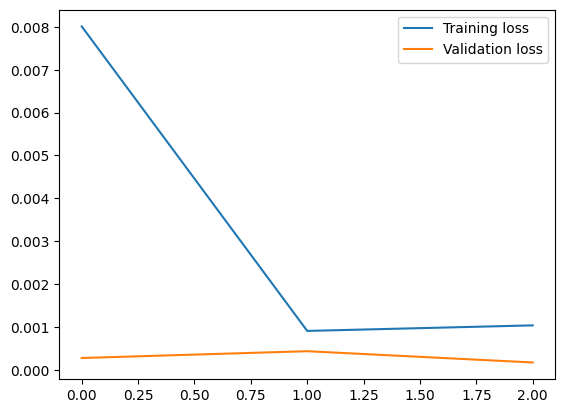

In [16]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

8/8 [==============================] - 1s 16ms/step


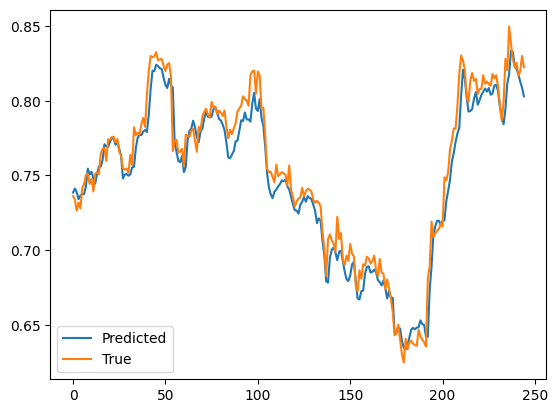

In [17]:
predictY = model.predict(testX)
plt.plot(predictY)
plt.plot(testY)
plt.legend(loc='best',labels=['Predicted','True'])


In [18]:
def calculate_mae(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

def calculate_mape(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
yo = testY.flatten()
oy = predictY.flatten()

print(f'mae = {calculate_mae(yo,oy)}')
print(f'rmse = {calculate_rmse(yo,oy)}')
print(f'mape = {calculate_mape(yo,oy)*100}%')



mae = 0.009005070902306013
rmse = 0.011872323767005167
mape = 118.85352498995259%
